# Introduction

In this notebook, we will load the same bearing dataset (public dataset) available in the link below:

Link: [Bearing dataset](https://csegroups.case.edu/bearingdatacenter/pages/welcome-case-western-reserve-university-bearing-data-center-website)

This dataset contains time series for normal and faulty bearings. There are several faulty modes. We will use the three faulty modes for the drive end bearing fault data. These files are available at the GitHub repository (https://github.com/m-small/ITTC-masterclass) but the original files can also be dowloaded from here:

Links: https://csegroups.case.edu/bearingdatacenter/pages/normal-baseline-data and https://csegroups.case.edu/bearingdatacenter/pages/12k-drive-end-bearing-fault-data 

In [51]:
from utils import *

import numpy as np
import ordpy
from matplotlib import pylab as plt
import networkx as nx
from matplotlib.lines import Line2D

# the following to lines will tell to the python kernel to always update the kernel for every utils.py
# modification, without the need of restarting the kernel.
%load_ext autoreload
%autoreload 2

# using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code
%matplotlib inline
#%matplotlib qt

plt.close('all') # close all figures (to make sure that memory is clean)
sns.set_style("whitegrid") # set seaborn style :), so every plot will looks nice

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### We will start by using time series from a dynamical system under different parameter settings. 

In [3]:
time_series = [logistic(a) for a in [3.05, 3.55, 4]]
time_series += [np.random.normal(size=100000)]

labels = [a for a in ['Logistic Period-2 (a=3.05)', 'Logistic Period-8 (a=3.55)', 
                      'Chaotic Logistic (a=4)', 'Gaussian Noise']]

Text(0.5, 0, 'Time Index')

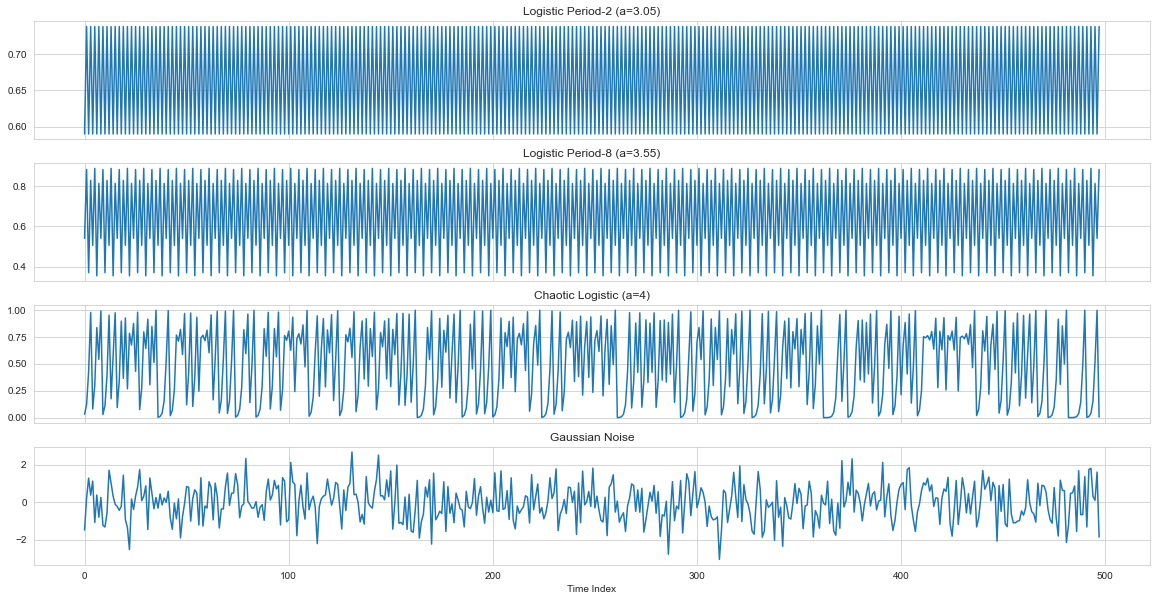

In [4]:
fig, axs = plt.subplots(nrows=4,ncols=1, figsize=(20,10), sharex=True)

for i,series in enumerate(time_series):
    axs[i].plot(series[2:500]) 
    axs[i].set_title(labels[i])

axs[i].set_xlabel('Time Index')

#### Let's check the distribution of ordinal patterns and the value of the permutation entropy for the four time series.

Permutation Entropy for Logistic Period-2 (a=3.05) is 0.21810429196947823
Permutation Entropy for Logistic Period-8 (a=3.55) is 0.4362085839229035
Permutation Entropy for Chaotic Logistic (a=4) is 0.7387434323444007
Permutation Entropy for Gaussian Noise is 0.9999732288206435


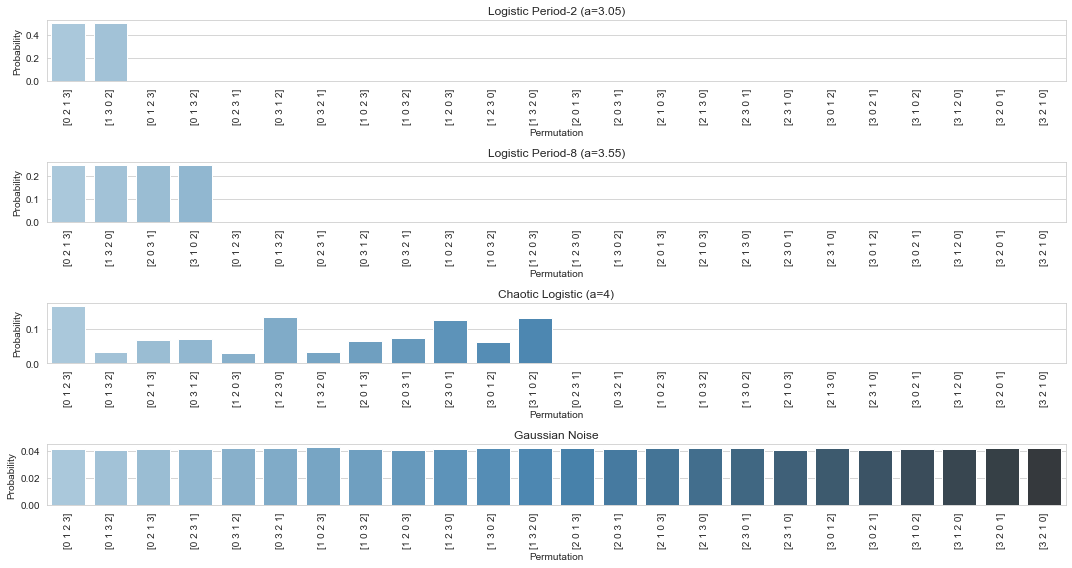

In [41]:
fig, axs = plt.subplots(nrows=4,ncols=1, figsize=(15,8))

m = 4
for i,series in enumerate(time_series):
    dist = ordpy.ordinal_distribution(series,dx=m, return_missing=True)
    dist_df = pd.DataFrame(data={'Probability':dist[1], 'Permutation':[str(d) for d in dist[0]]})
    barplot = sns.barplot(x='Permutation', y='Probability', data=dist_df, 
                          palette=("Blues_d"), ax = axs[i])
    for item in barplot.get_xticklabels():
        item.set_rotation(90)
        
    axs[i].set_title(labels[i])
    pe = ordpy.complexity_entropy(series, dx=m)[0]
    print('Permutation Entropy for {} is {}'.format(labels[i], pe))
    
plt.tight_layout()

#### Now computing the value of the Conditional Entropy

In [98]:
for i,series in enumerate(time_series):
    dist = ordpy.ordinal_distribution(series,dx=m, return_missing=True)
    ord_sequence = ordpy.ordinal_sequence(series, dx=m)
    s_matrix = compute_stochastic_matrix(ord_sequence)
    c_pe = compute_conditional_pe(s_matrix,dist[1])
    
    print('Conditional Entropy for {} is {}'.format(labels[i],c_pe))

Conditional Entropy for Healthy is 0.0
Conditional Entropy for Inner Race fault is 0.000737003344565098
Conditional Entropy for Ball fault is 7.149227316795149
Conditional Entropy for Outer race fault is 94.37548569279537


#### Now let's have a look at the resulting networks

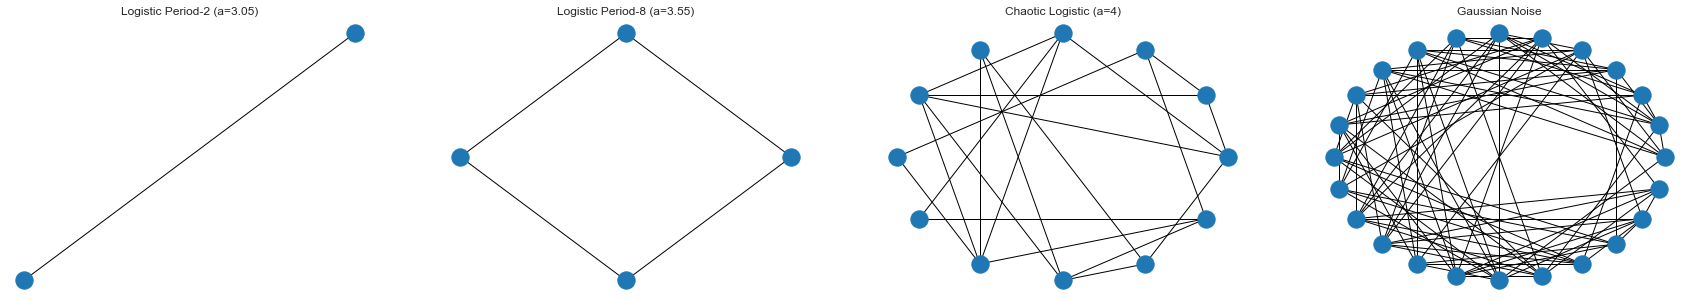

In [42]:
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(30,5))

for i,series in enumerate(time_series):
    vertices, edges, weights = ordpy.ordinal_network(series, dx=m,overlapping=True)
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    nx.draw_circular(G,ax=axs[i])
    axs[i].set_title(labels[i])

#### What about the Global Node Entropy?

In [43]:
for i,series in enumerate(time_series):
    g_node_e = ordpy.global_node_entropy(series,dx=4)
    print('Global Node Entropy for {} is {}'.format(labels[i],g_node_e))

Global Node Entropy for Logistic Period-2 (a=3.05) is 0.0
Global Node Entropy for Logistic Period-8 (a=3.55) is 0.0
Global Node Entropy for Chaotic Logistic (a=4) is 0.9209075983505619
Global Node Entropy for Gaussian Noise is 1.921067898012107


#### We only see all possible ordinal patterns for the Gaussian noise!! So let's have a look at the fraction of missing patterns

In [44]:
for i,series in enumerate(time_series):
    fraction_missing_patterns = ordpy.missing_patterns(series,dx=4, return_missing=False)
    
    print('Proportion of Missing Patterns for {} is {}'.format(labels[i],fraction_missing_patterns))

Proportion of Missing Patterns for Logistic Period-2 (a=3.05) is 0.9166666666666666
Proportion of Missing Patterns for Logistic Period-8 (a=3.55) is 0.8333333333333334
Proportion of Missing Patterns for Chaotic Logistic (a=4) is 0.5
Proportion of Missing Patterns for Gaussian Noise is 0.0


#### Proposed exercises:

1) So far we used overlapping windows to find the ordinal patterns. What happens if we set overlapping=False in the previous ordinal partition networks and related entropies? Draw the networks and check how the various entropies behave. 

We plot the first points of each series below. 

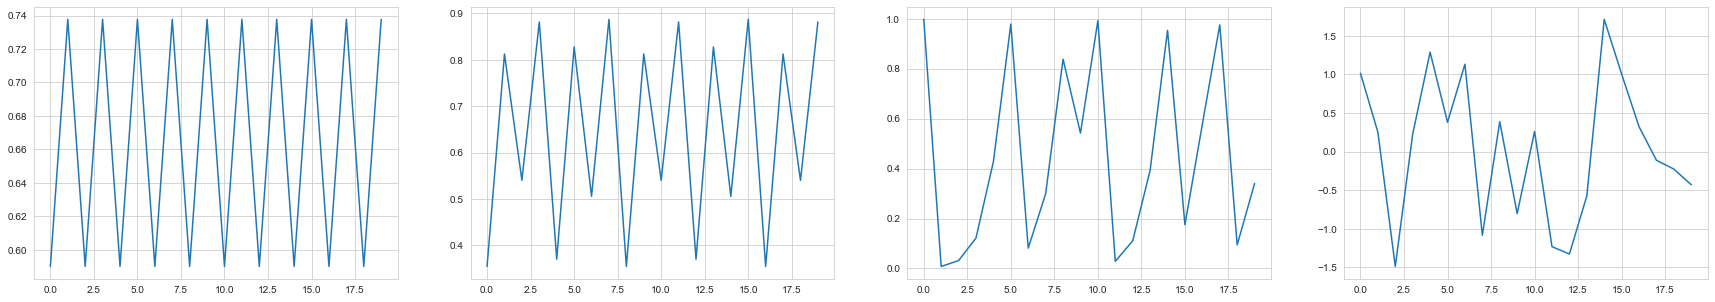

In [45]:
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(30,5))

for i,series in enumerate(time_series):
    axs[i].plot(series[:20])

2) Try the network properties investigated in the first notebook. Are they able to characterise the different system parameters for this Logistic data? Perhaps to make it harder, generate time series from the Logistic map with closer parametes, say, 3.8 and 4. Can the entropies distinguish them?

3) How would be the cycle length distribution or the degree distribution for the chaotic time series and the random time series?

#### Now let's see how we can use these measures to detect changes in the dynamics using that same Bearing Data.

In [46]:
labels = ['Healthy', 'Inner Race fault', 'Ball fault', 'Outer race fault']
df = pd.DataFrame(columns=labels)

ts_len = 2050
df_healthy = pd.read_csv('./Bearing_healthy.csv')
df['Healthy'] = df_healthy.iloc[:ts_len,0]

df_f1 = pd.read_csv('./Bearing_fault_1.csv')
df['Inner Race fault'] = df_f1.iloc[:ts_len,0]

df_f2 = pd.read_csv('./Bearing_fault_2.csv')
df['Ball fault'] = df_f2.iloc[:ts_len,0]

df_f3 = pd.read_csv('./Bearing_fault_3.csv')
df['Outer race fault'] = df_f3.iloc[:ts_len,0]

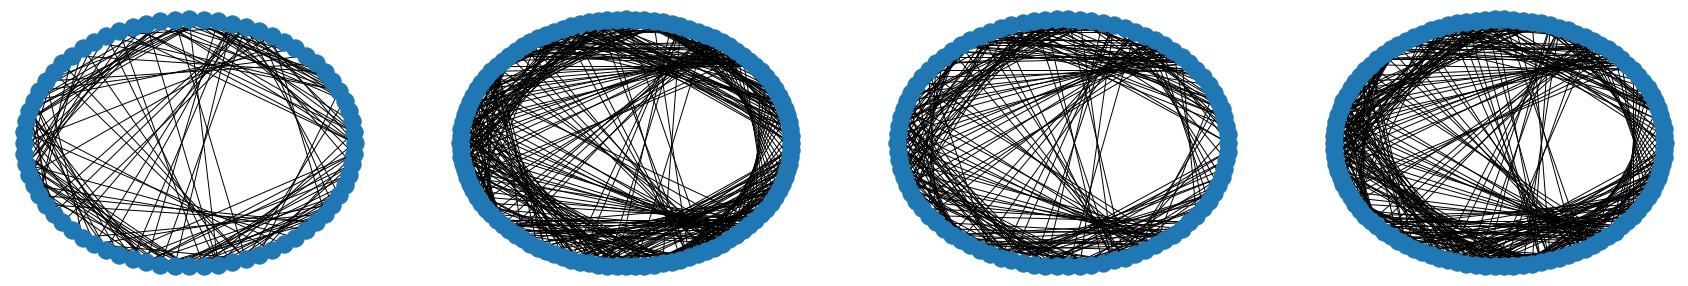

In [47]:
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(30,5))

m=5
for i,col in enumerate(df.columns):
    vertices, edges, weights = ordpy.ordinal_network(df[col], dx=m)
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    nx.draw_circular(G,ax=axs[i])

#### Hum, visually the three faulty modes are not clearly detectable. Let's see if the entropies can capture their difference. 

In [48]:
win_len = 1000

list_feat = ['fraction missing patterns','global node entropy', 'conditional entropy', 'permutation entropy']

print('Calculating features for healthy')
df_h = get_net_ordinal_properties_window(m,df[labels[0]],0,list_feat,win_len)

print(f'Calculating features for {labels[1]}')
df_f1 = get_net_ordinal_properties_window(m,df[labels[1]],1,list_feat,win_len)

print(f'Calculating features for {labels[2]}')
df_f2 = get_net_ordinal_properties_window(m,df[labels[2]],2,list_feat,win_len)

print(f'Calculating features for {labels[3]}')

measures_network = {}
measures_network[m] = pd.concat([df_h,df_f1,df_f2,df_f3],axis=0)

  0%|          | 0/1050 [00:00<?, ?it/s]

Calculating features for healthy


  0%|          | 0/1050 [00:00<?, ?it/s]

Calculating features for Inner Race fault


  0%|          | 0/1050 [00:00<?, ?it/s]

Calculating features for Ball fault


  0%|          | 0/1050 [00:00<?, ?it/s]

Calculating features for Outer race fault


100%|██████████| 1050/1050 [09:55<00:00,  1.76it/s]


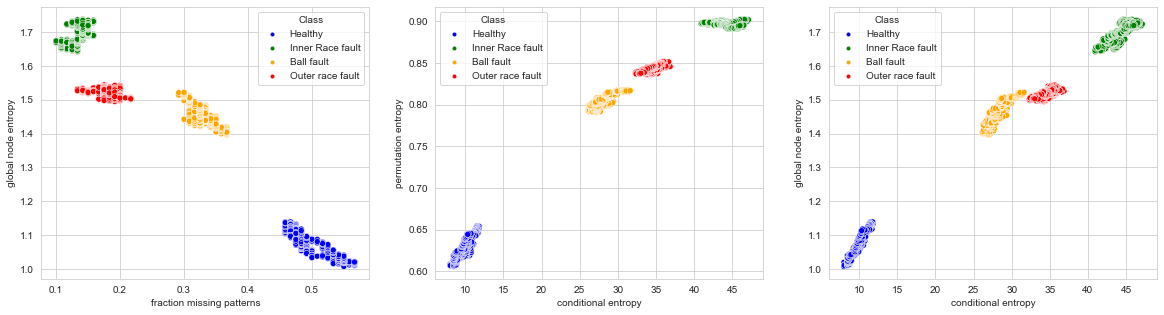

In [56]:
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(20,5))

color_dict = dict({0:'blue',
                  1:'green',
                  2: 'orange',
                  3: 'red'})

data = measures_network[m]
measure1 = 'fraction missing patterns'
measure2 = 'global node entropy'
sns.scatterplot(x=measure1,y=measure2,data=data, hue='Class', palette=color_dict, ax=axs[0])
    
measure1 = 'conditional entropy'
measure2 = 'permutation entropy'
sns.scatterplot(x=measure1,y=measure2,data=data, hue='Class', palette=color_dict, ax=axs[1])
    
measure1 = 'conditional entropy'
measure2 = 'global node entropy'
sns.scatterplot(x=measure1,y=measure2,data=data, hue='Class', palette=color_dict, ax=axs[2])  

custom = []
for l, _ in enumerate(labels):
    custom.append(Line2D([], [], marker='.', color=color_dict[l], linestyle='None'))
    
for i in range(len(axs)):
    axs[i].legend(custom, labels, loc='best',title="Class",
                    fancybox=True)

#### Slinding window for the bearing data

In [113]:
# Loading the data
df_normal_2_faulty = pd.read_csv('./Bearing_healthy_to_fault_2.csv')
df_normal_2_faulty = df_normal_2_faulty.iloc[:,0]

In [115]:
label = 0
measures_network_normal_2_faulty = get_net_ordinal_properties_window(m,df_normal_2_faulty,label,list_feat,win_len)

100%|██████████| 29000/29000 [4:35:38<00:00,  1.75it/s]     


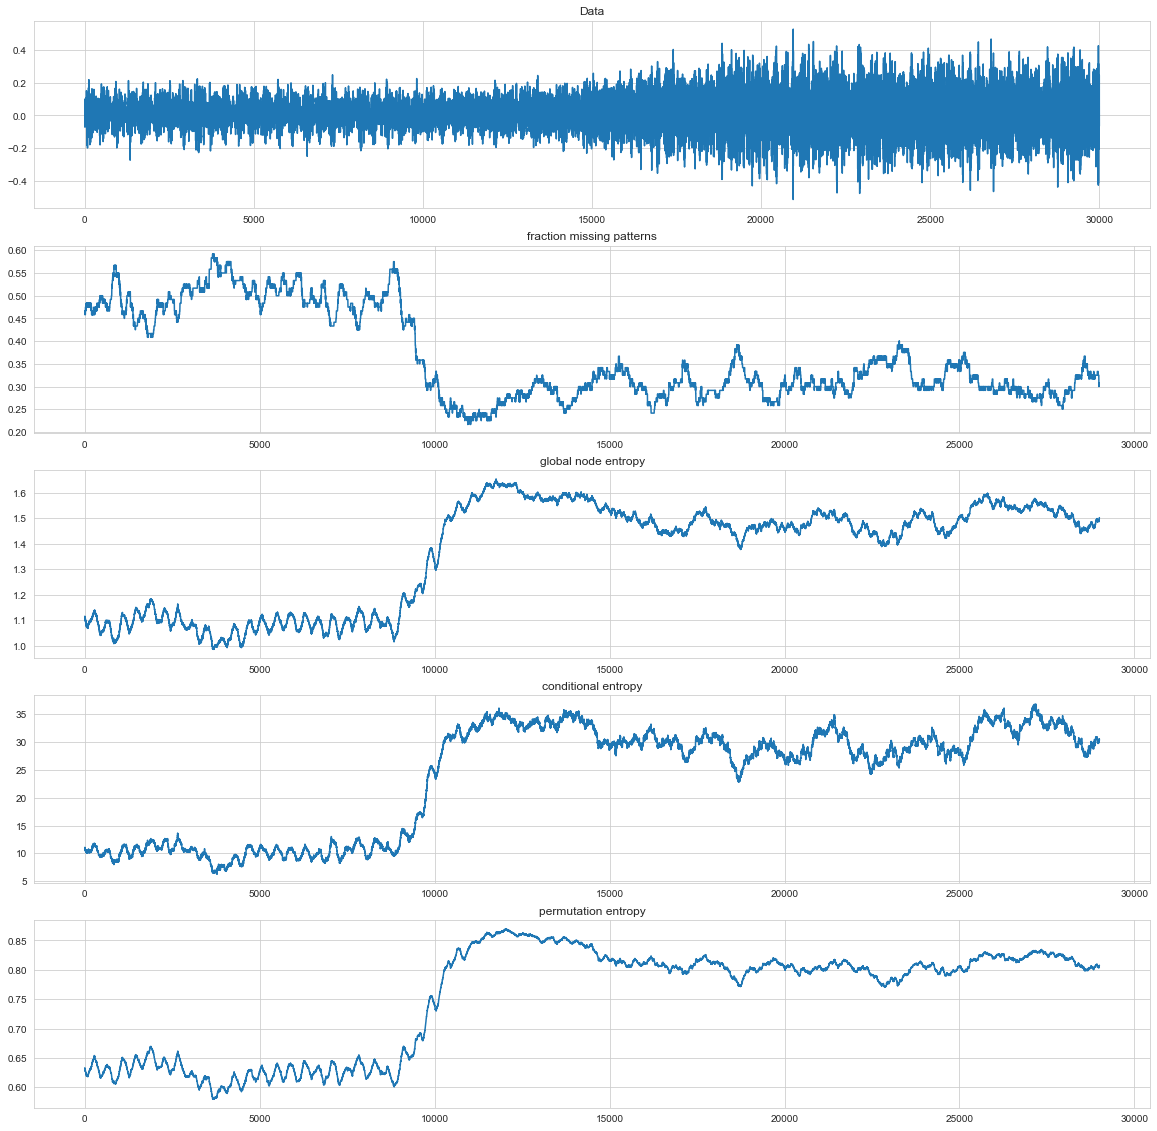

In [116]:
fig, axs = plt.subplots(nrows=5,ncols=1, figsize=(20,20))

data = measures_network_normal_2_faulty
axs[0].plot(df_normal_2_faulty)
axs[0].set_title('Data')
axs[1].plot(data['fraction missing patterns'])
axs[1].set_title('fraction missing patterns')
axs[2].plot(data['global node entropy'])
axs[2].set_title('global node entropy')
axs[3].plot(data['conditional entropy'])
axs[3].set_title('conditional entropy')
axs[4].plot(data['permutation entropy'])
axs[4].set_title('permutation entropy');

#### Proposed exercises:

1) Check if we can detect the change for the other faulty modes.

2) What happens for different values of m and/or window sizes? 

### Your turn

Try the approaches discussed today in your data. If you don't have one, we suggest the following:

1) Download the [df.csv](https://www.dropbox.com/s/wbrtxw143qfggyc/df.csv?dl=0). It contains several sensor measurements and several failure events along time. However, only some of the sensors bring dynamic information that is relavant to the events.

2) Apply the techniques discussed today to identify which sensors are relevant for detecting changes before the event happens. 